# Pytorch
Ejemplo de clasificador con Pytorch, comentado en español. 

El cuaderno de Jupyter se ha desarrollado con Visual Code y puedes encontrar el código en https://github.com/josegemez/pytorch_mnist 

Se ha desarrollado en python 3.10.4 

## Import
Con las primeras lineas vamos a importar los paquetes que básicos de Pytorch. 

In [1]:
import torch
import torchvision

## Variables Generales

In [2]:
batch_size_train = 64
batch_size_test = 64

## Transformaciones 

In [3]:
transforms=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,)) #media y desviacion estandar para el dataset de mnist en concreto
                            ])

## Dataset 

In [4]:
dataset_mnist = torchvision.datasets.MNIST('/files/', train=True, download=True, transform=transforms)  #descarga el dataset de pytorch                  

## Train-test split

In [5]:
train_size = int(0.8 * len(dataset_mnist)) #tamaño de los datos de entrenamiento 80%
test_size = len(dataset_mnist) - train_size #tamaño test
train_dataset, test_dataset = torch.utils.data.random_split(dataset_mnist, [train_size, test_size]) #realiza un train-test split

## Dataloader

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,  batch_size=batch_size_train, shuffle=True,num_workers=5,pin_memory=True) #cargador de los datos en batch de entrenamiento

Vamos a ver que "pinta" tiene cada elemento del cargador

In [7]:
x, y = next(iter(train_loader)) #asignamos el primer batch a las variables x e y. La variable X contrendra las imagenes e y contrendra las etiquetas

x es un batch, por lo que la primera dimensión coincidira con el batch size 

In [8]:
from matplotlib.pyplot import imshow

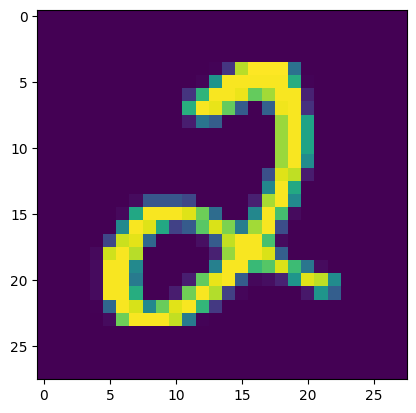

In [9]:
imshow(x[0].view(28,28).numpy()); # transformamos el primer elemento del batch una matriz de numpy y mostramos con matplotlib

In [10]:
x #comprobamos los datos

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

In [11]:
y #comprobamos las etiquetas

tensor([2, 4, 6, 7, 5, 5, 0, 0, 3, 4, 7, 5, 8, 0, 1, 4, 5, 8, 1, 0, 1, 3, 6, 3,
        4, 4, 7, 3, 9, 4, 6, 8, 6, 1, 8, 0, 8, 9, 2, 3, 0, 7, 2, 4, 0, 1, 2, 9,
        8, 1, 8, 2, 3, 2, 9, 3, 3, 2, 0, 4, 1, 4, 1, 0])

## Dataset Test

In [12]:
test_loader = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size_test, shuffle=True, num_workers=5,pin_memory=True)              

Ya tenemos los datos preparados, ahora vamos a crear la red

In [13]:
learning_rate   =   0.01 
momentum   =   0.5
n_epochs = 20

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np

## MLP

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        n_hidden1 = 128
        n_hidden2 = 64
        self.fc1 = nn.Linear(28*28,n_hidden1) #capa "fuly connect" entrada 28*28 (tamaño de la imagen) 50 neuronas
        self.fc1_drop = nn.Dropout(0.2) #dropout (regularizacion) 20% 
        self.fc2 = nn.Linear(n_hidden1, n_hidden2) #capa fully connect 50 neuronas 
        self.fc2_drop = nn.Dropout(0.2) #dropout (regularizacion) 20%
        self.fc3 = nn.Linear(n_hidden2, 10) #capa de salida numero de salida igual al de etiquetas

    def forward(self, x):
        x = x.view(-1, 28*28) #cambia la forma del tensor, -1 para quitar la dimensiones anteriores y dejarlo todo en una vector de 256 elementos
        x = F.relu(self.fc1(x)) #capa fully connect y luego activacion relu
        x = self.fc1_drop(x) #dropout (regularizacion)
        x = F.relu(self.fc2(x)) #capa fully connect y luego activacion relu
        x = self.fc2_drop(x) #dropout (regularizacion)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1) #soft max (estimacion estadistica 0-1 de la probabildad de que sea de un etiqueta u otra)

## Convolutional

((1*5*5)+1)*32 = 352
704 

In [59]:
class Net(nn.Module):
    
  def __init__(self):
    super(Net, self).__init__()  # pre Python 3.3 syntax

    self.conv1 = nn.Conv2d(1, 32, 5)  # chnl-in, out, krnl
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.fc1 = nn.Linear(1024, 512)   # [64*4*4, x]
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)     # 10 classes
    self.pool1 = nn.MaxPool2d(2, stride=2)
    self.pool2 = nn.MaxPool2d(2, stride=2)
    self.drop1 = nn.Dropout(0.25)
    self.drop2 = nn.Dropout(0.50)

  def forward(self, x):
      # convolution phase         # x is [bs, 1, 28, 28]
      z = F.relu(self.conv1(x))   # Size([bs, 32, 24, 24])
      z = self.pool1(z)           # Size([bs, 32, 12, 12])
      z = self.drop1(z)
      z = F.relu(self.conv2(z))   # Size([bs, 64, 8, 8])
      z = self.pool2(z)           # Size([bs, 64, 4, 4])

      # neural network phase
      z = z.reshape(-1, 1024)     # Size([bs, 1024])
      z = F.relu(self.fc1(z))     # Size([bs, 512])
      z = self.drop2(z)
      z = F.relu(self.fc2(z))     # Size([bs, 256])
      z = self.fc3(z)             # Size([bs, 10])
      return z


In [33]:
from torchsummary import summary

In [18]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')
device

device(type='cuda')

In [60]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
criterion =  nn.CrossEntropyLoss().to(device)


In [61]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
           Dropout-3           [-1, 32, 12, 12]               0
            Conv2d-4             [-1, 64, 8, 8]          51,264
         MaxPool2d-5             [-1, 64, 4, 4]               0
            Linear-6                  [-1, 512]         524,800
           Dropout-7                  [-1, 512]               0
            Linear-8                  [-1, 256]         131,328
            Linear-9                   [-1, 10]           2,570
Total params: 710,794
Trainable params: 710,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 2.71
Estimated Total Size (MB): 2.97
-------------------------------------------

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
count_parameters(model)

2160522

In [23]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [62]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=20, device='cuda'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parametros
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Funcion de perdida (e.g. nn.CrossEntropyLoss())
    train_dl : 
        Dataloader para los datos de entrenamiento.
    val_dl :
        Dataloader para los datos de validacion.
    epochs : int
        Numero de epocas
    device : string
        'cuda' para entrenamiento en gpu y 'cpu' para entrenamiento en cpu

    Retorno
    -------
    Diccionario
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(epochs):

        # --- Entrenamiento en los datos de entrenamientos -----------------------------
        model.train() #modelo en forma de entrenamiento    
        train_loss         = 0.0 #perdida inicializada en cero
        num_train_correct  = 0 #numero de elementos donde la prediccion coincide con la etiqueta "true positive"
        num_train_examples = 0 #inicializa el numero de elementos sobre los que se ha realizado entrenamiento

        for batch in train_dl:

            optimizer.zero_grad() #pone los gradientes a cero

            x    = batch[0].to(device) #datos al dispositivo (cpu o gpu)
            y    = batch[1].to(device) #idem
            yhat = model(x) # y predichos 
            loss = loss_fn(yhat, y) #calcula la perdida entre los "y predichos" y los "y etiquetas"

            loss.backward() #retropropagación
            optimizer.step() #se mueve el gradiente un paso (learning rate por el gradiente negativo)

            train_loss         += loss.data.item() * x.size(0) 
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item() #compureba los elementos correctos
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- Evaluacion en los datos de test -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:
            with torch.no_grad():
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                yhat = model(x)
                loss = loss_fn(yhat, y)

                val_loss         += loss.data.item() * x.size(0)
                num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
                num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
              (epoch+1, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

In [63]:
history = train(model,optimizer,criterion, train_loader, test_loader, n_epochs, 'cuda')

train() called: model=Net, opt=SGD(lr=0.010000), epochs=20, device=cuda

Epoch   1/ 20, train loss:  0.62, train acc:  0.81, val loss:  0.15, val acc:  0.95
Epoch   2/ 20, train loss:  0.16, train acc:  0.95, val loss:  0.10, val acc:  0.97
Epoch   3/ 20, train loss:  0.11, train acc:  0.97, val loss:  0.07, val acc:  0.98
Epoch   4/ 20, train loss:  0.09, train acc:  0.97, val loss:  0.06, val acc:  0.98
Epoch   5/ 20, train loss:  0.07, train acc:  0.98, val loss:  0.05, val acc:  0.98
Epoch   6/ 20, train loss:  0.07, train acc:  0.98, val loss:  0.05, val acc:  0.99
Epoch   7/ 20, train loss:  0.06, train acc:  0.98, val loss:  0.04, val acc:  0.99
Epoch   8/ 20, train loss:  0.05, train acc:  0.98, val loss:  0.04, val acc:  0.98
Epoch   9/ 20, train loss:  0.05, train acc:  0.99, val loss:  0.04, val acc:  0.99
Epoch  10/ 20, train loss:  0.05, train acc:  0.99, val loss:  0.04, val acc:  0.99
Epoch  11/ 20, train loss:  0.04, train acc:  0.99, val loss:  0.04, val acc:  0.99
Epo

In [ ]:
torch.save(model.state_dict(), 'results/model.pth')
torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [ ]:
model.load_state_dict(torch.load('results/model.pth'))
model.eval()


In [64]:
import matplotlib.pyplot as plt

(0.0, 3.0)

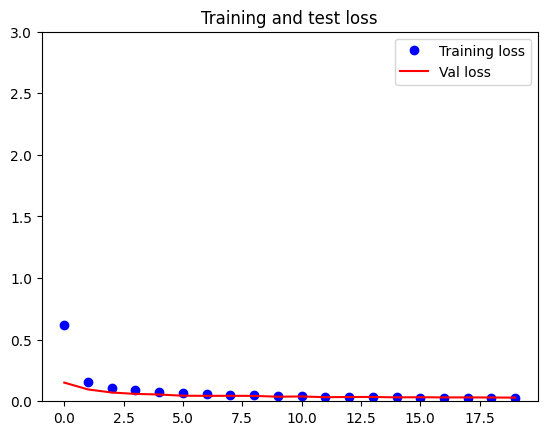

In [65]:
fig = plt.figure()
plt.plot(range(len(history['loss'])), history['loss'], 'bo', label='Training loss')
plt.plot(range(len(history['val_loss'])), history['val_loss'], c="red",label='Val loss')
plt.title('Training and test loss')
plt.legend()
plt.ylim([0, 3])

(0.0, 1.0)

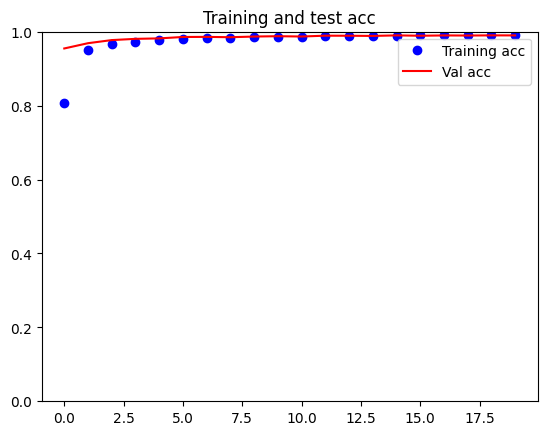

In [66]:
fig = plt.figure()
plt.plot(range(len(history['acc'])), history['acc'], 'bo', label='Training acc')
plt.plot(range(len(history['val_acc'])), history['val_acc'], c="red",label='Val acc')
plt.title('Training and test acc')
plt.legend()
plt.ylim([0, 1])